In [9]:
# I found out that python actually has a built in TAS diagram available for import
# I used a terminal program with pip install pyrolite
# https://pyrolite.readthedocs.io/en/develop/examples/util/TAS.html

# pyrolite is not a built in module so it needs to be reinstalled every time the Kernel is restarted. 
# This cell installs it instead.

import sys
!{sys.executable} -m pip install pyrolite

In [10]:
# Import necessary packages here, e.g.
import numpy as np # for numerical operations
import matplotlib.pyplot as plt  # for plotting
import pandas as pd  # for data manipulation
from datetime import datetime  # for restructuring of time and date columns
from scipy import stats  # for statistical analysis
from scipy.stats import linregress  # for linear regression
from statistics import mode  # to calculate the mode of the VEI data
from pyrolite.util.classification import TAS  # this is required to generate the TAS plots

# Examination of Physical and Chemical Properties of Volcanic Sites Used to Determine Risk

**Christina Stuhl**   

OCEAN 215 Final Project  
Autumn 2024

## Introduction

My final project was focused on the properties determining the hazard that volcanic sites pose to the surrounding populated areas. This required limited knowledge of how the chemical properties of a volcano effect the explosivity of it's eruptions, and how those eruptions might be triggered by or trigger seismic activity. I also wanted to explore how comparable volcanic activity was from one volcano to another (i.e. comparing Ruapehu with Mt. St. Helens to determine the behavior of Mt. Etna.) I was expecting the chemical properties of sampled rock to show that more rhyolitic or silica rich rock would have more explosive (higher VEI) eruptions, and that primarily basaltic sites like those originating in marine environments, would be more effusive.I also expected shallow earthquakes to always produce higher magnitude earthquakes more frequently. That said I was not expecting seimsic data to provide any significant insight on risk given that it is erratic and is not always the cause of or caused by a volcanic eruption, especially if the volcano in question falls on a tectonic plate boundary.


## Data sources:
<!-- List each data source used in your project. For each dataset, include: 
     - Where you accessed it from 
     - Date you accessed/downloaded it 
     - Data collection process
     - Relevant variables (including unit) 
     - Spatial and temporal coverage and resolution 
     - Description of any obstacles or challenges you faced in obtaining the dataset
     - URL to the dataset if available -->

- EarthChem Decade
  - I downloaded all of my data from the EarthChem database, which acts as a collection point for several other databases, this allowed me to acquire all of the information I needed in a wide range of metrics in a single download for each site (this still took a long time because I did some of my data cleaning in the original excel files that I downloaded). 
  - EarthChem data repositories used
    - EarthChem Portal - all chemical data
    - The Smithsonian - all VEI data and eruptive history, and eruption dates.
    - IRIS - seismic data (depth, magnitude, and dates)
  - I used many different data formats to achieve what I wanted to with this project and didn't think to download the current set as a regular excel file until late last week (11/26/2024). I was originally getting converted files as comma delimited files (.csv)
  - All of the samples collected from earth chem were solid volcanic or plutonic samples. Most of the volcanoes were terrestrial, the one or two that were not were sampled during multiple cruises over a number of years.
  - Relevant variables included: 
    - seismic depth (km)
    - volcanic explosivity index units (VEI)
    - magnitude (richter scale units)
    - all chemical data is represented in WT%
  - Coverage is variable from site to site. Anywhere from thousands to a dozen samples were collected depending on accessibility at each site.
  - There weren't any significant obstacles. I struggled with the .csv files, but the most time consuming portion of collection was downloading 16 very large files.
<br>

## 1. File imports and cleaning 

This section includes the overall file imports for each excel sheet in the for loops that I used throughout my project. All of the figures in each section were made from one of the individual excel sheets downloaded in this section.

In [11]:
# List of all of the xlsx files I need to import
volcanoes = ['augustine.xlsx', 'ruapehu.xlsx', 'okataina.xlsx', 
             'whakaari.xlsx', 'pagan.xlsx', 'taal.xlsx', 'pinatubo.xlsx', 
             'helens.xlsx', 'krafla.xlsx', 'palma.xlsx', 'lengai.xlsx', 
             'etna.xlsx', 'vulcano.xlsx', 'santorini.xlsx', 'gorely.xlsx', 'bezy.xlsx']

# List of the colors needed for visuals
c_index = ['lightcoral', 'indianred', 'salmon', 'sandybrown', 'cadetblue', 'lightseagreen', 'powderblue', 
           'slategrey', 'cornflowerblue', 'slateblue', 'mediumpurple', 'orange', 'maroon', 'red', 
           'sienna', 'saddlebrown', 'goldenrod', 'gold', 'olivedrab', 'darkolivegreen', 'seagreen']

# This took a little while to do, just because there wasn't an automated way to put each one in a list.

In [12]:
# recurring sheet names
# earthquake magnitude and depth data
# this sheet required datetime conversions
iris = 'IRIS Data'

# VEI data
# this sheet required datetime conversions
smith = 'Smithsonian Data'

# chemical analysis
chem = 'EarthChem Data'

# list of file names for full variable volcanoes
# This was really important for naming global variables inside of for loops and keeping track of which volcano was being displayed in figures
names = []
for volcano in volcanoes:
    name =  volcano.split('.')[0] # split the file name to create a new variable name
    names.append(name) # add a new name to the array "names"

In [13]:
# read-in data from excel files downloaded earlier and index the columns required for analysis
# I also imported latitude and longitude values 
# i is iris and s is smithsonian

# the position variable keeps track of which volcano file in the volcano files list is being read-in
position = 0
for volcano in volcanoes:
    # assign a new name to each variable by calling the values from the names list
    # read in the excel sheets given the file name from the volcanoes list
    i = globals()[names[position] + '_iris'] = pd.read_excel(volcano, sheet_name = iris) # reads in the iris sheet
    i['Time'] = pd.to_datetime(i['Time'], format = "%Y-%m-%dT%H:%M:%S") # sorts and indexes datetimes in the iris sheet
    globals()[names[position] + '_depth'] = i['Depth'] # names the variable ex. augustine_depth = i['Depth']
    globals()[names[position] + '_mag'] = i['Magnitude']
    globals()[names[position] + '_time'] = i['Time']
    globals()[names[position] + '_lat'] = i['Latitude']
    globals()[names[position] + '_long'] = i['Longitude']
    
    s = globals()[names[position] + '_smith'] = pd.read_excel(volcano, sheet_name = smith) # reads in the smithsonian sheet
    s['Start Date'] = pd.to_datetime(s["Start Date"], format = 'mixed', errors='coerce')
    vei = globals()[names[position] + '_vei'] = s['Explosivity Index Max']
    sdate = globals()[names[position] + '_sdate'] = s['Start Date']
    
    # The commented section below was a seperate sheet from a MaGa data set that included gas flux over time
    # there was an error that I could not fix so it wasn't included.
    #m = globals()[names[position] + '_maga'] = pd.read_excel(volcano, sheet_name = maga)
    #m['Date'] =  pd.to_datetime(m['Date'], format = 'mixed', errors='coerce')
    #globals()[names[position] + '_date'] = m['Date']
    #globals()[names[position] + '_flux'] = m['Flux']

    position = position + 1 

## 1. Physical Properties of 16 Volcanic Sites

This section redefines a few variables and compares the VEI values from the Smithsonian database to the IRIS depth and magnitude data from EarthChem. This is what I used to compare the physical behaviors of each site to the severity of each eruption.

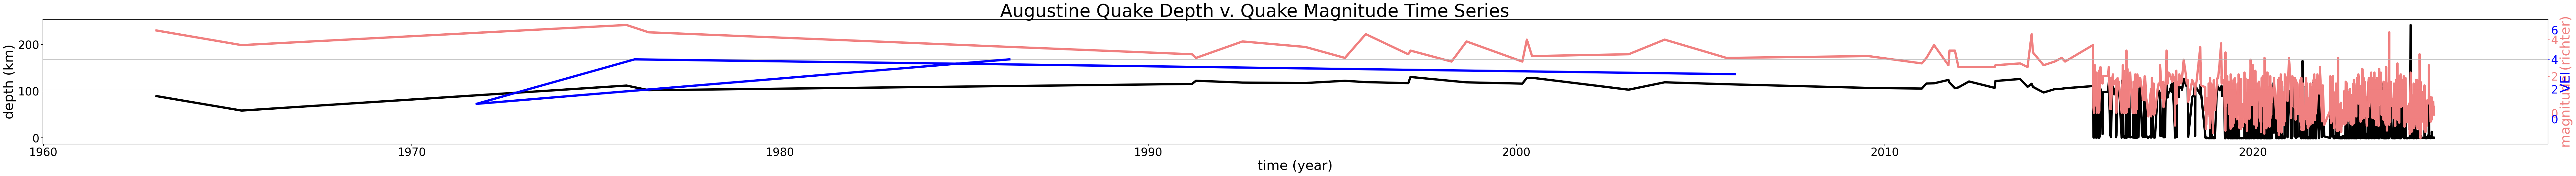

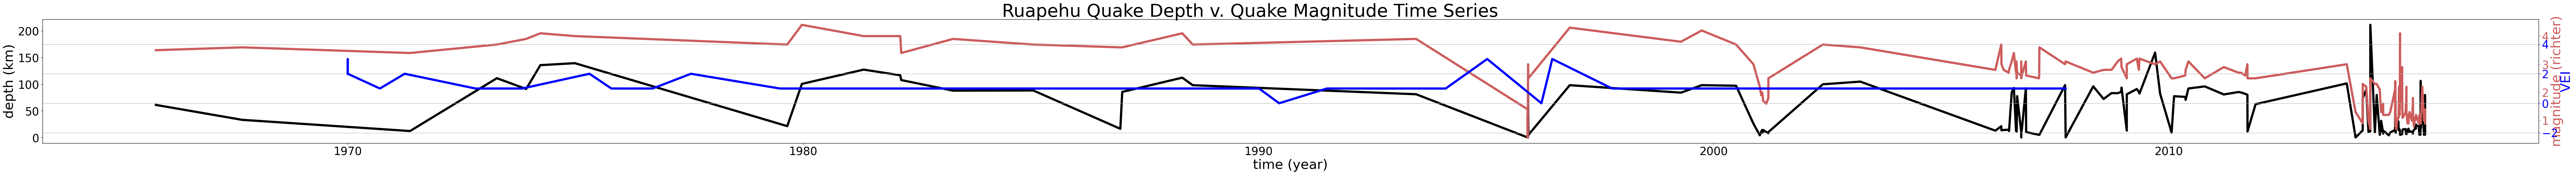

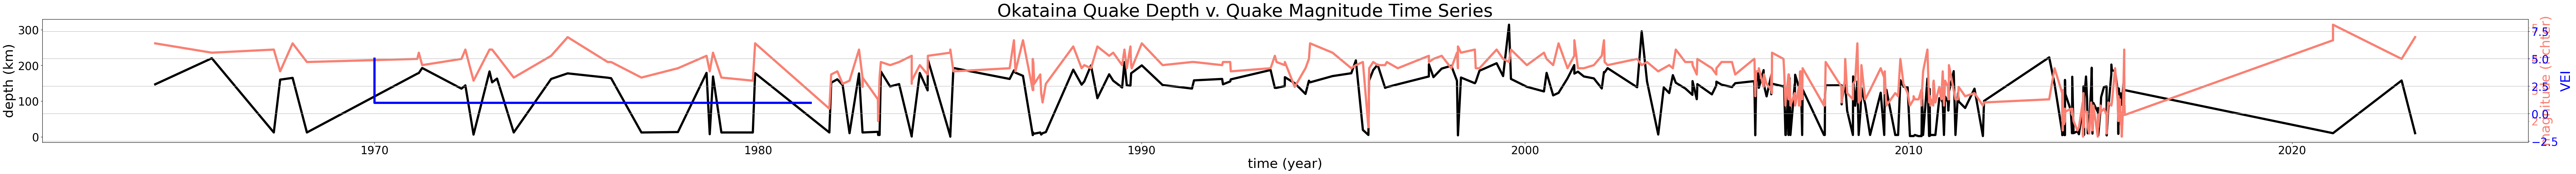

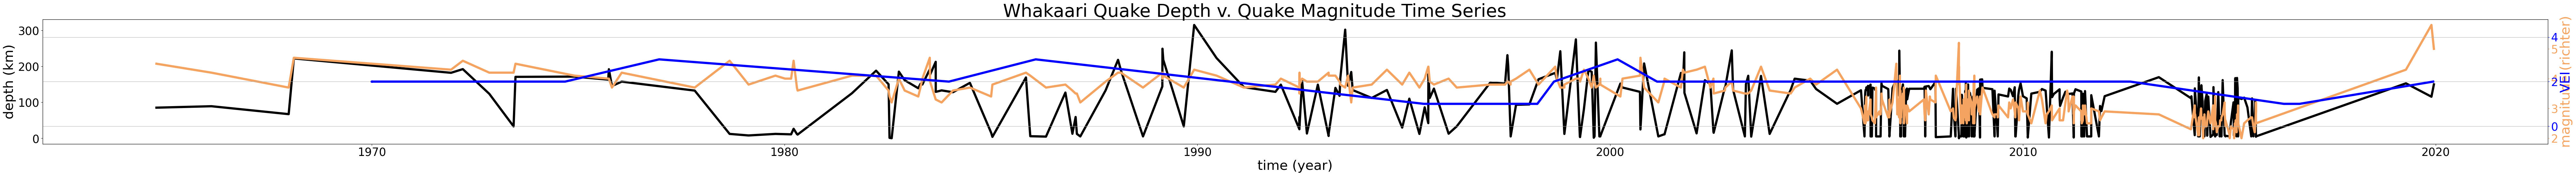

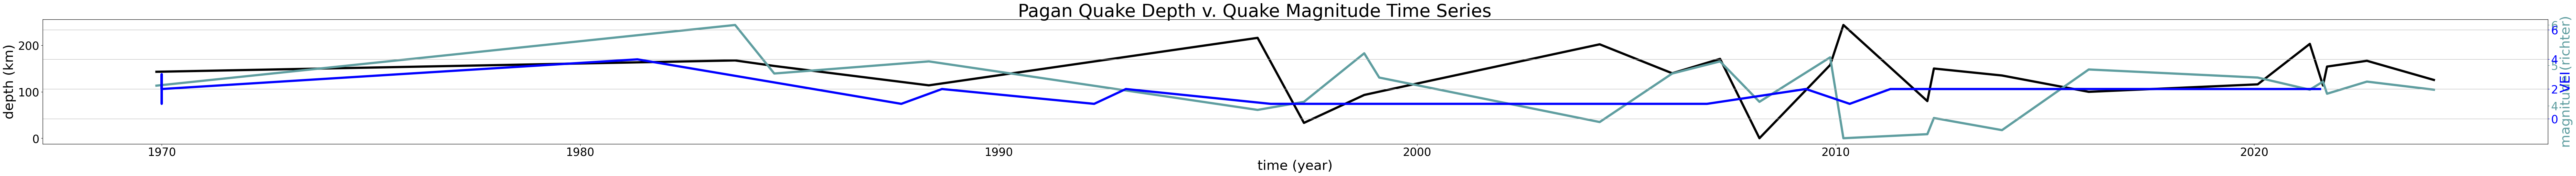

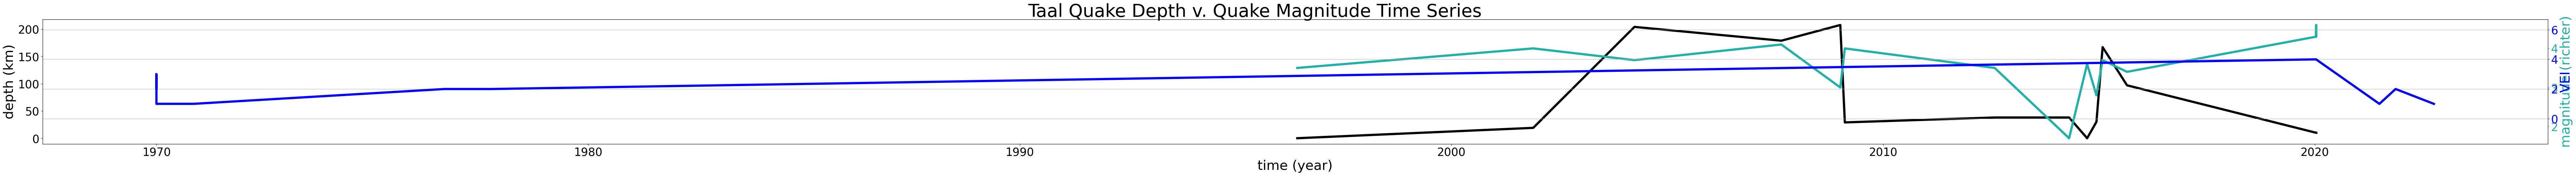

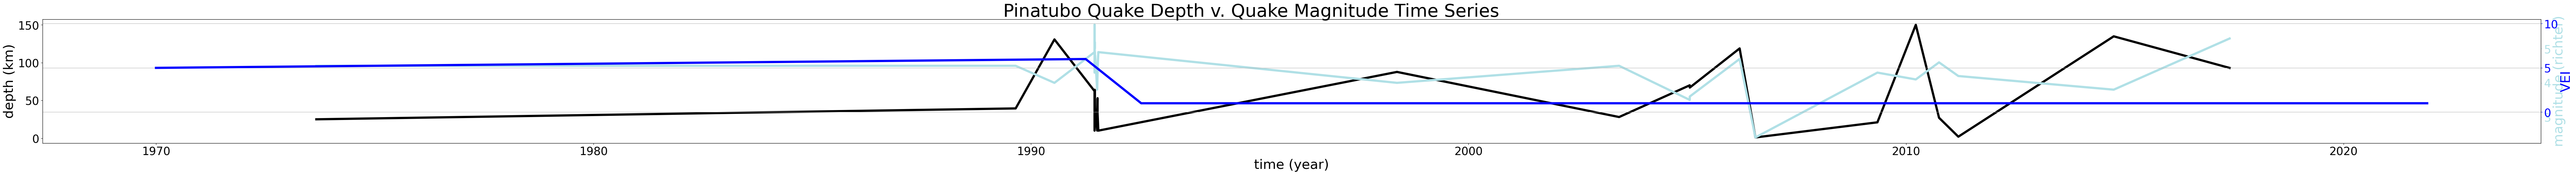

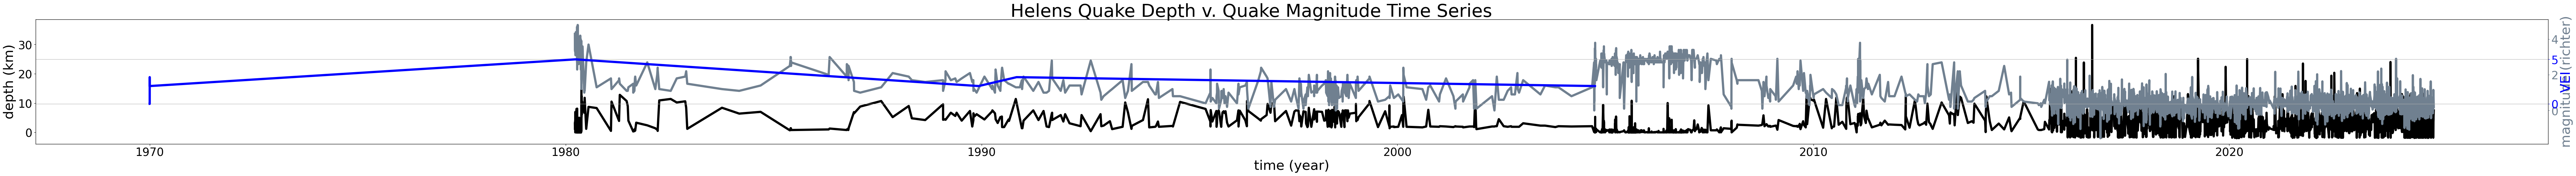

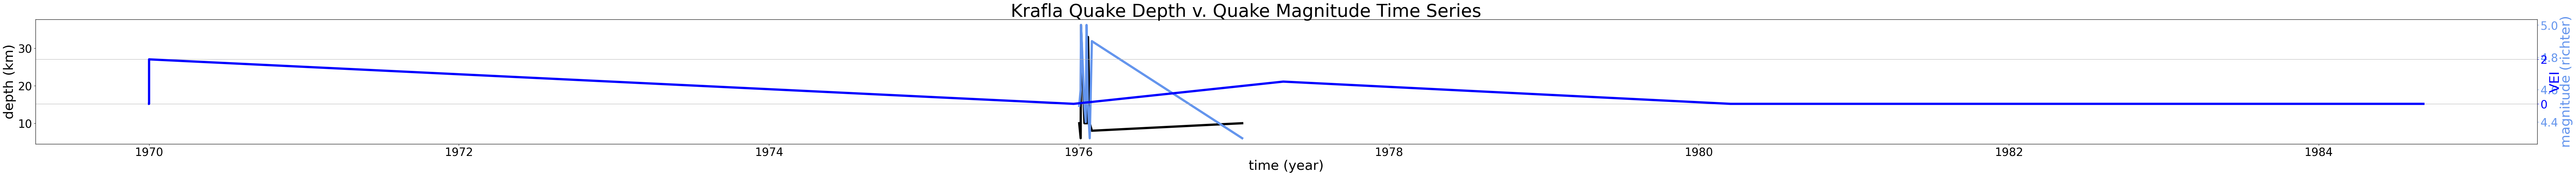

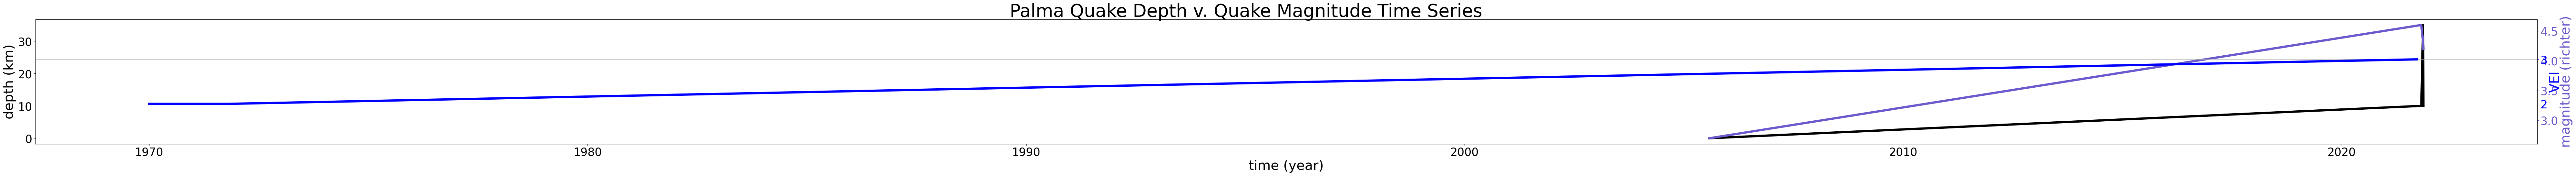

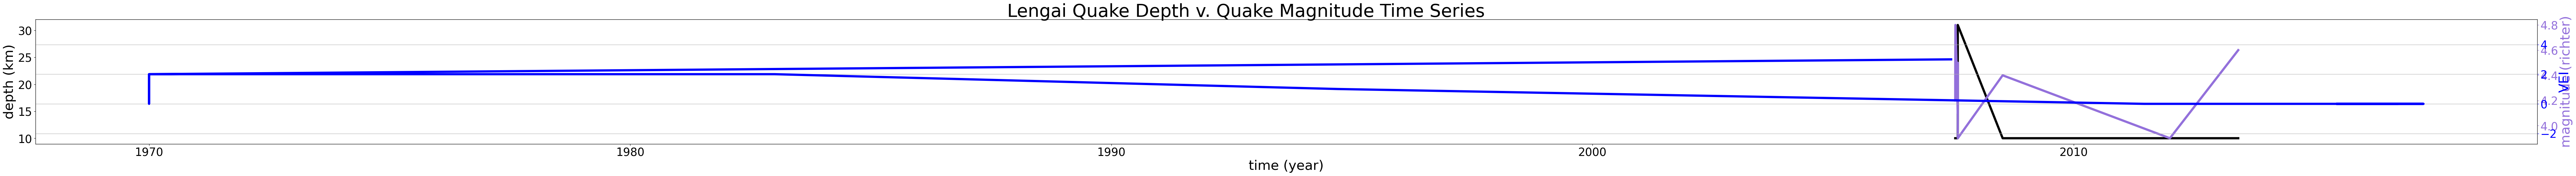

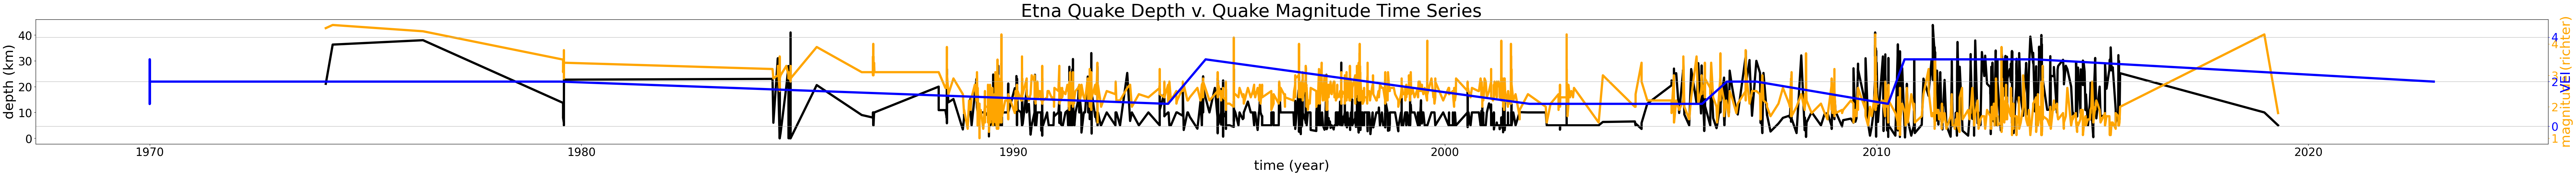

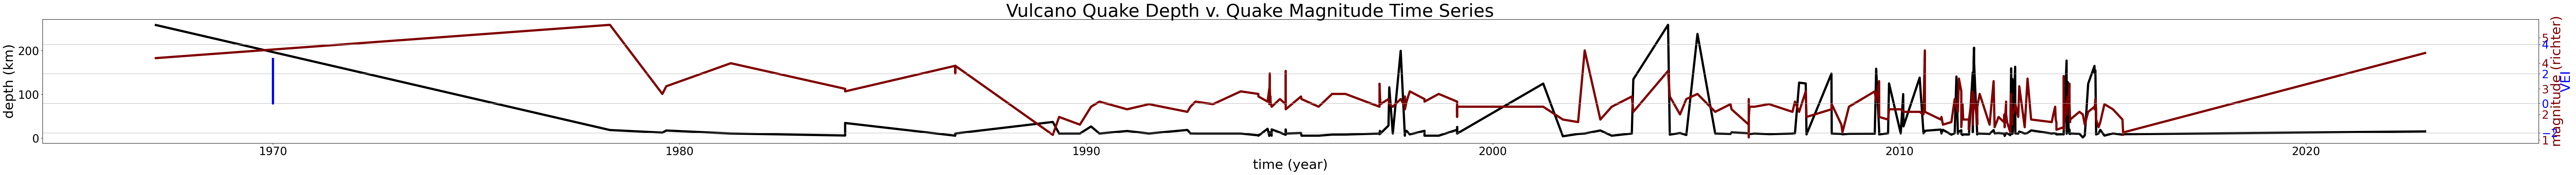

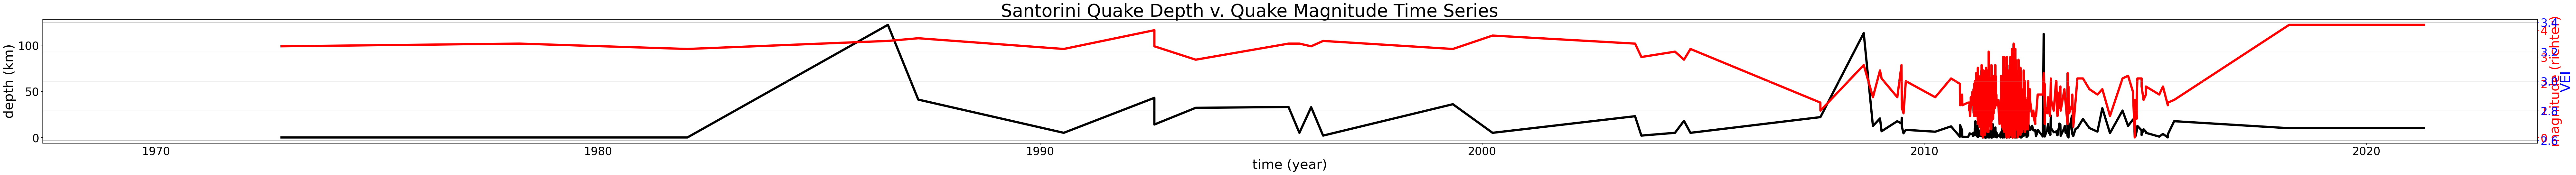

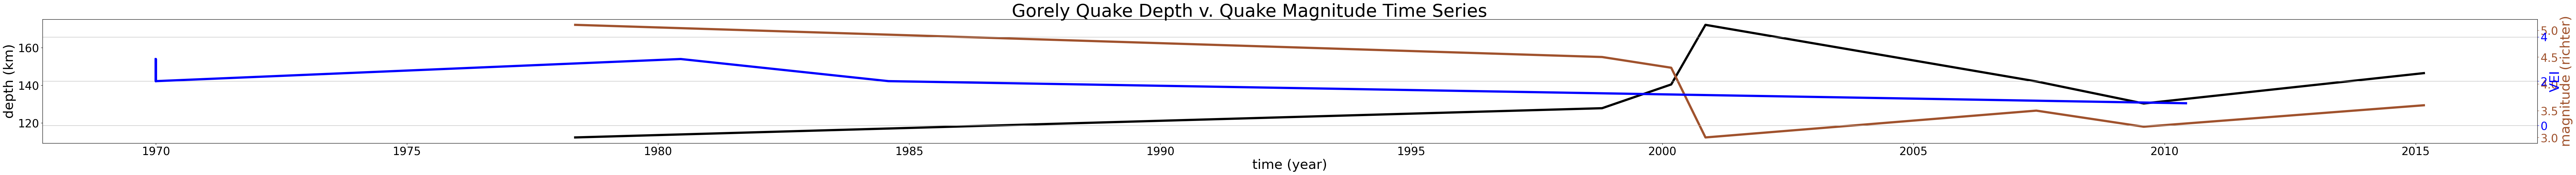

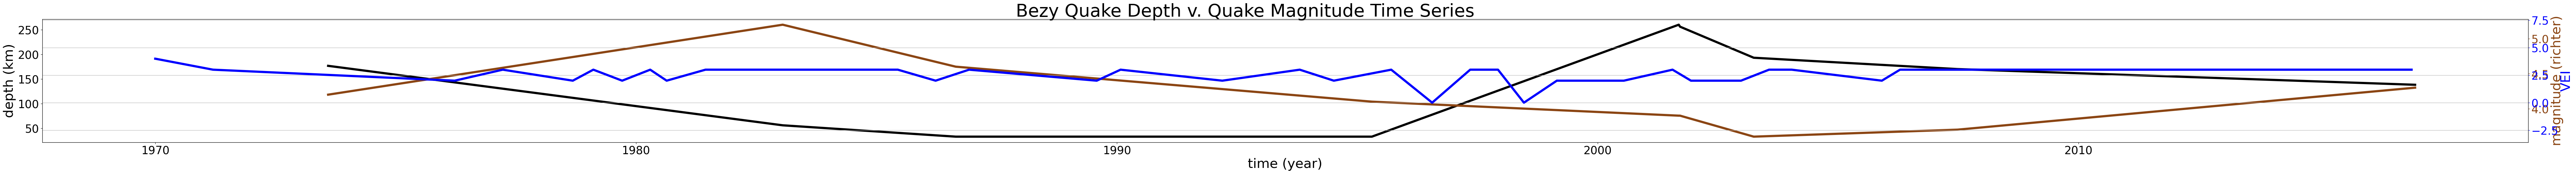

In [14]:
# For the sake of efficiency I tried to complete all data manipulation inside the same for loop as the graphs were made
# The number of files was just to much to make a seperate cleaning and plotting sheet for every file when I could just do all 16 of them in one loop.

position = 0
for volcano in volcanoes:
    i = globals()[names[position] + '_iris']
    s = globals()[names[position] + '_smith']
    # Depth v. Magnitude over time 
    #iris
    # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html
    itime = i['Time'] # x-value
    idepth = i['Depth'] # y-values
    imag = i['Magnitude'] # y-values
    
    sdate = s['Start Date']
    svei = s['Explosivity Index Max']
    
    s2 = s[s['Start Date'].dt.year >= 1970]
    s2 = s2[s2['Start Date'].dt.year <= 2025]
    
    sdate_new = s2['Start Date']
    svei_new = s2['Explosivity Index Max']
    
    # Create a figure and a set of subplot
    fig, ax1 = plt.subplots(figsize = (100, 5))
    #fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # seismic depth axis
    ax1.plot(itime, idepth, 'black', linewidth = 5) # plot depth over time plots
    ax1.set_xlabel('time (year)', fontsize = 30)
    ax1.set_ylabel('depth (km)', color='black', fontsize = 30)
    ax1.tick_params(axis= 'y', colors='black', labelsize = 25)
    ax1.tick_params(axis= 'x', colors='black', labelsize = 25)

    # earthquake magnitude axis
    ax2 = ax1.twinx()
    ax2.plot(itime, imag, color=c_index[position], linewidth = 5) # plot magnitude over time plots, these data points are at the same time as the depth plots.
    ax2.set_ylabel('magnitude (richter)', color=c_index[position], fontsize = 30)
    ax2.tick_params(axis='y', colors=c_index[position], labelsize = 25)
    
    # VEI axis
    ax3 = ax1.twinx()
    ax3.plot(sdate_new, svei_new, color= 'blue', linewidth = 5)
    ax3.set_ylabel('VEI', color= 'blue', fontsize = 30)
    ax3.tick_params(axis='y', colors='blue', labelsize = 25)
    
    title = names[position]
    fig.suptitle(title.capitalize() + ' Quake Depth v. Quake Magnitude Time Series', fontsize = 40)
    plt.grid()
    plt.margins(x = 0.9, y =0.9)
    plt.show()
    
   # move along the length of the volcanoes list
    position = position + 1 

**Figure 1 Caption:** Seismic activity over time compared to the intensity of eruptions on the same time scale. There is genearlly an inverse relationship between depth and magnitude. VEI is much harder to compare, and because seimic data is so erratic it does not appear to play a significant role in the intensity of eruptions.

## 2. Statistical Analysis of Physical Properties of 16 Volcanic Sites 

This is where I did my data analysis or "attempted" data analysis. I used the same for loop I have been using prior to this cell. I wanted to plot the depth against the magnitude and find out if there was a common trend at each site and between sites. Every site ended up being very different and the spread of depth and magnitude points is very interesting to visualize.

Magnitude is related to depth at Augustine


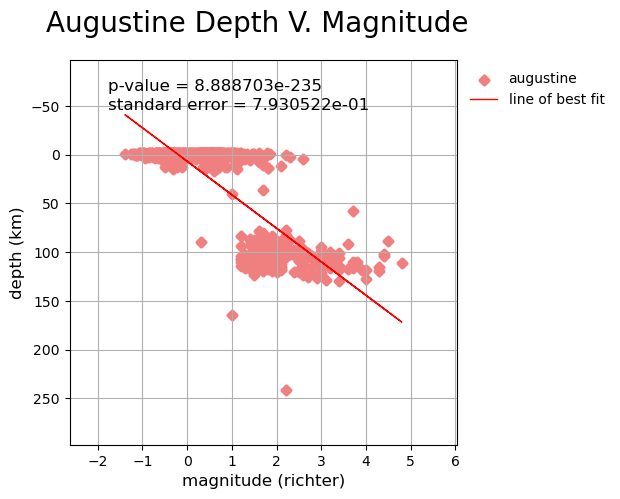

Magnitude is related to depth at Ruapehu


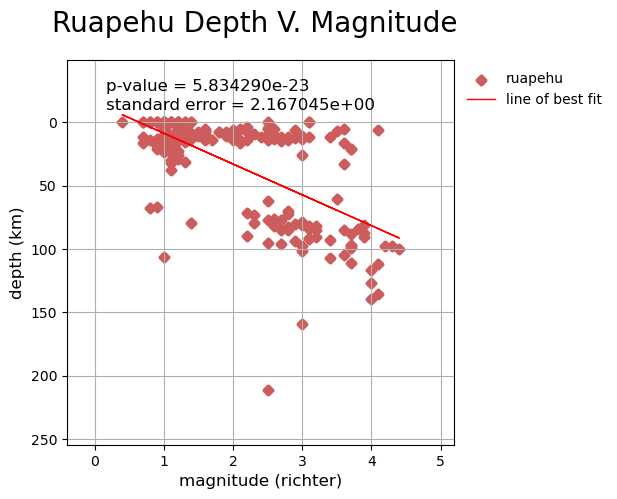

Magnitude is related to depth at Okataina


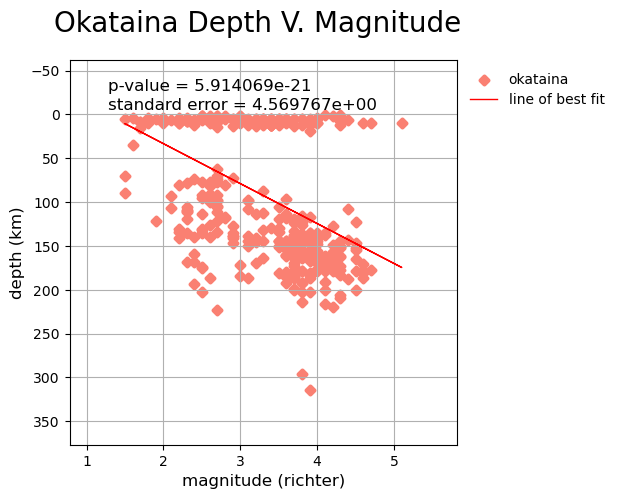

Magnitude is related to depth at Whakaari


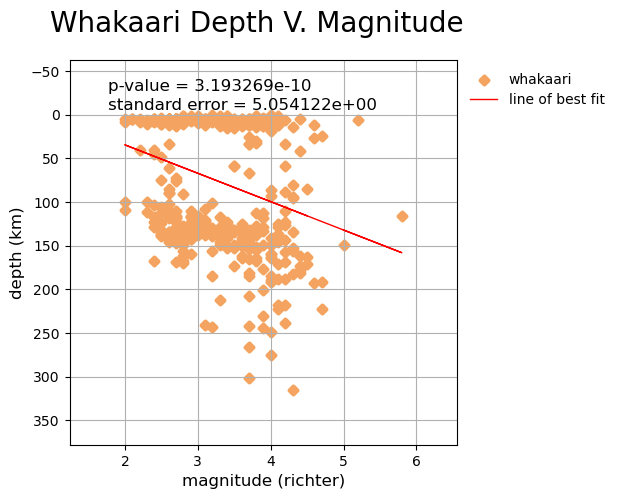

Magnitude cannot be correlated to depth at Pagan


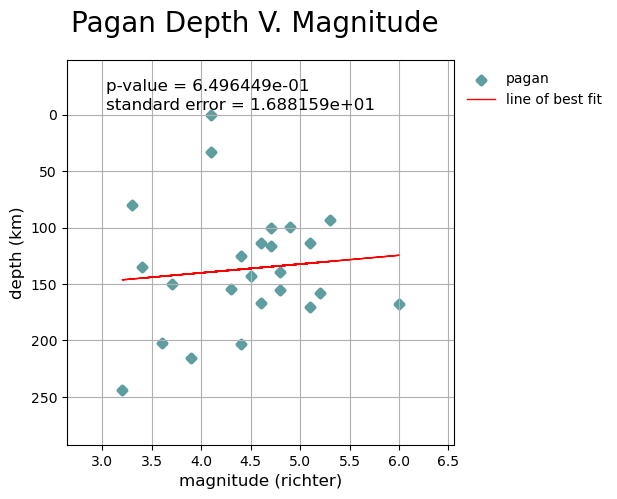

Magnitude cannot be correlated to depth at Taal


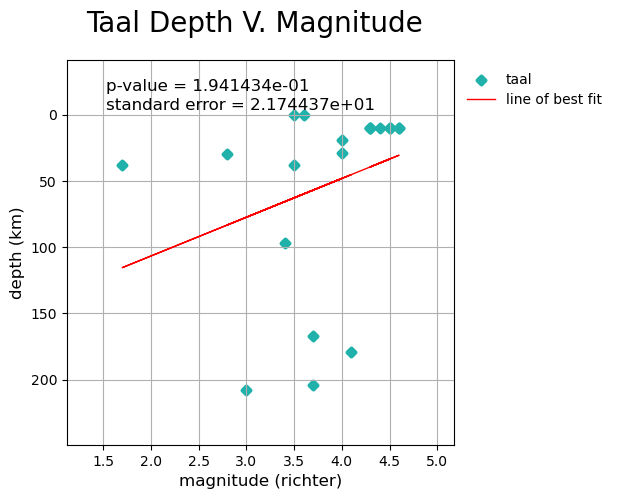

Magnitude cannot be correlated to depth at Pinatubo


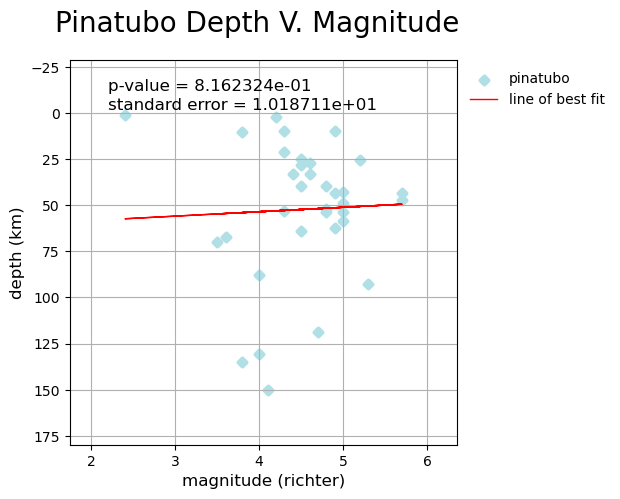

Magnitude is related to depth at Helens


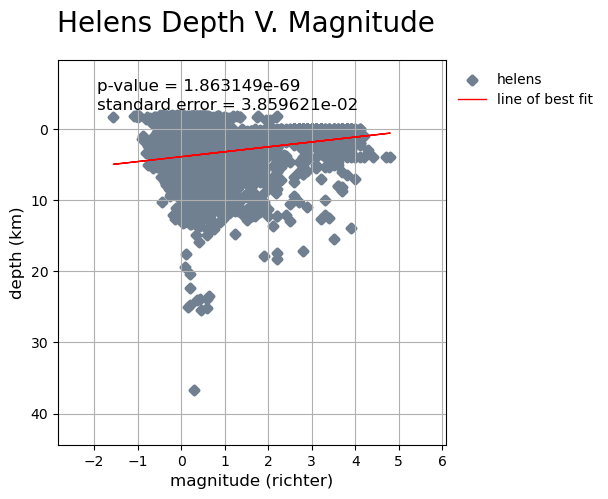

Magnitude cannot be correlated to depth at Krafla


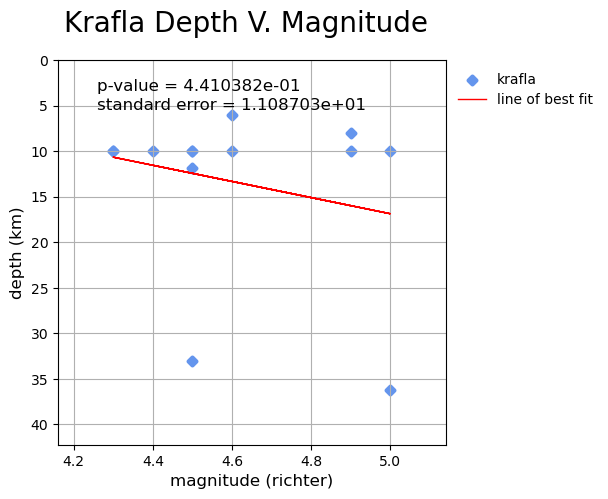

Magnitude cannot be correlated to depth at Palma


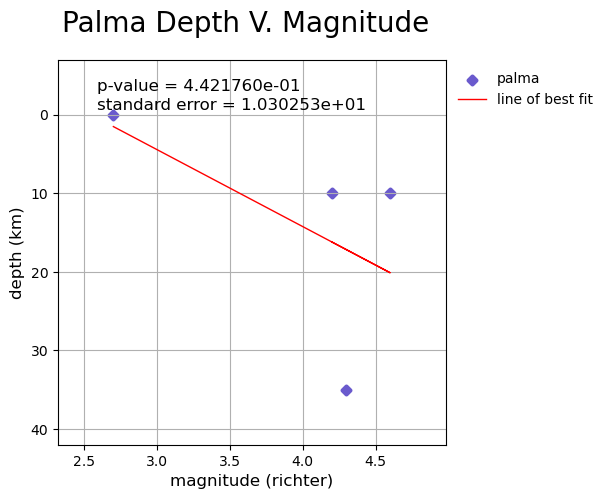

Magnitude cannot be correlated to depth at Lengai


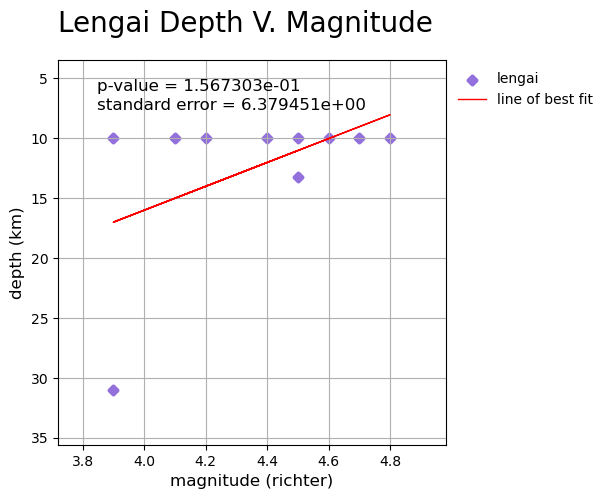

Magnitude is related to depth at Etna


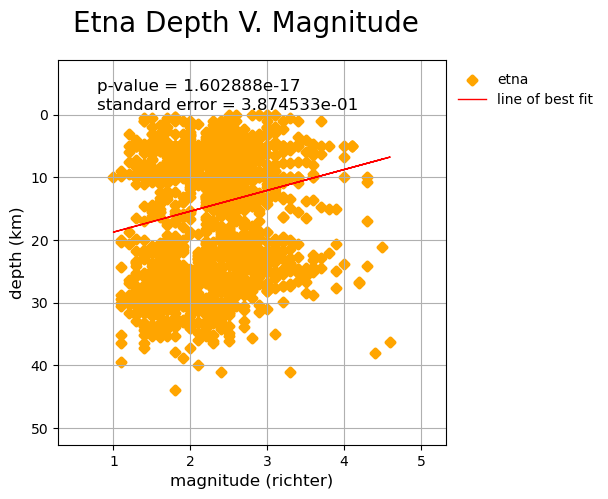

Magnitude is related to depth at Vulcano


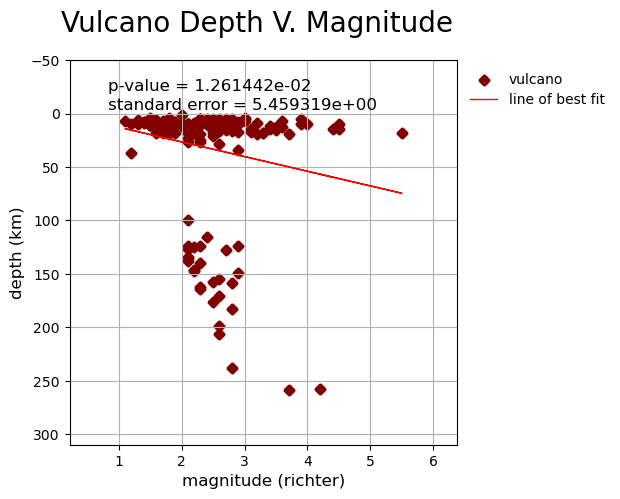

Magnitude is related to depth at Santorini


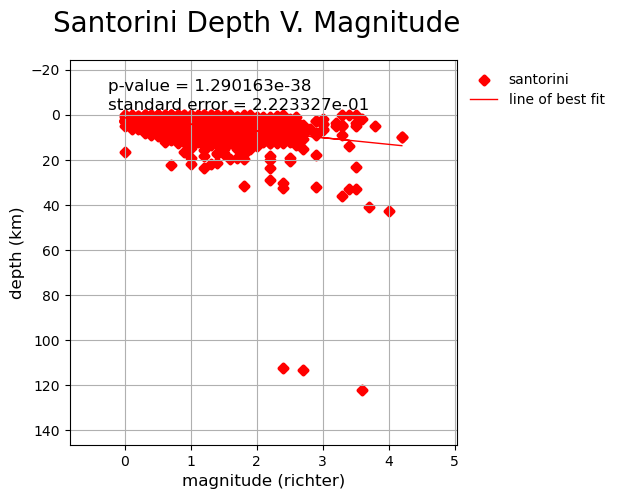

Magnitude is related to depth at Gorely


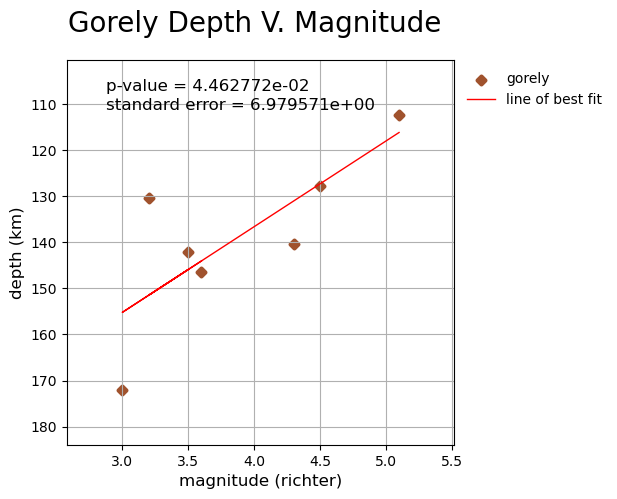

Magnitude cannot be correlated to depth at Bezy


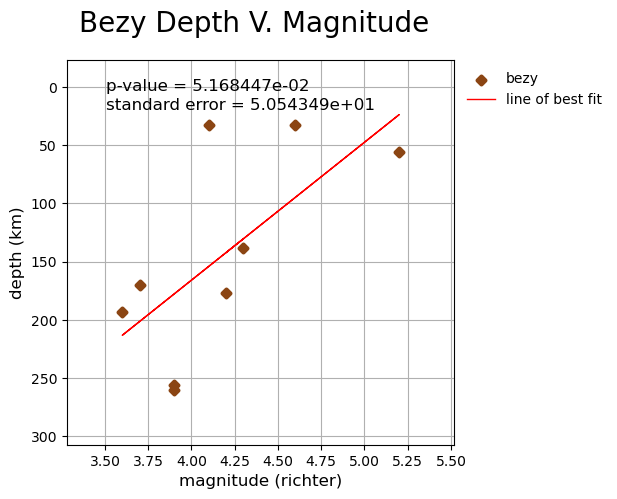

In [19]:
# This portion is for the analysis of physical data
position = 0

for volcano in volcanoes:
    i = globals()[names[position] + '_iris']
    idepth = i['Depth'] # y-values
    imag = i['Magnitude'] # y-values
    # seismic depth axis
    fig, ax = plt.subplots(figsize = (5, 5))
    plt.scatter(imag, idepth, color = c_index[position], linewidth = 3, label = names[position])

    
    #ax3 = ax1.twinx()
    #ax3.plot(sdate_new, svei_new, color= 'gray', linewidth = 3)
    #ax3.set_ylabel('VEI', color= 'gray', fontsize = 20)
    #ax3.tick_params(axis='y', colors='gray')
    plt.margins(x = 0.2, y =0.2)
    plt.legend()
    
    a, b = np.polyfit(imag, idepth, 1)
    i_slope, i_intercept, i_r_value, i_p_value, i_std_err = stats.linregress(imag, idepth) # linear regression
    plt.plot(imag, i_intercept + i_slope*imag, 'r', label = 'line of best fit')
    plt.text(0.1, 0.95, f'p-value = {i_p_value:e}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.text(0.1, 0.90, f'standard error = {i_std_err:e}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    #plt.plot(imag, a*imag + b, color = 'black', label='Line of best fit')           
    plt.xlabel('magnitude (richter)')
    plt.ylabel('depth (km)')
    ax.invert_yaxis()
    ax.grid()
    plt.legend()
    title = names[position]
    fig.suptitle(title.capitalize() + ' Depth V. Magnitude', fontsize = 20)
    if i_p_value < 0.05:
        print('Magnitude is related to depth at ' + title.capitalize())
    else: 
        if i_p_value >= 0.05:
            print('Magnitude cannot be correlated to depth at ' + title.capitalize())
    # move along the length of the volcanoes list
    plt.show()
    position = position + 1 

<!-- Describe how this figure helps address your research question. What patterns or insights can you observe? -->
**Figure 2 Caption:** Linear Regression models for each of the sites explored, comparing depth and magnitude. This led me to believe that each volcano is incredibly unique and that they cannot be used to predict the behavior even with similar chemical profiles.

## 3. Chemical Properties of 16 Volcanic Sites

This is where I cleaned, manipulated, and plotted my chemical data on TAS plots. This required the pyrolite module that I imported at the beginning of the program.

In [16]:
# I had to clean the data that I hadn't imported yet

#https://volcano.oregonstate.edu/faq/what-lava-made
#The above link is where I found the target compounds I wanted to use
# Chemical Index 
chem_index = pd.read_csv('chemical_index.csv')
index_comp = chem_index['Unnamed: 0']
index_basalt = chem_index['Basalt']
index_andesite = chem_index['Andesite']
index_dacite = chem_index['Dacite']
index_rhyolite = chem_index['Rhyolite']
index_trachyte = chem_index['Trachyte']

new_row = [{'Unnamed: 0': 'alkali sum', 'Basalt': index_basalt[8]+index_basalt[9], 
            'Andesite': index_andesite[8]+index_andesite[9], 'Dacite':index_dacite[8]+index_dacite[9],
            'Rhyolite': index_rhyolite[8]+index_rhyolite[9], 'Trachyte': index_trachyte[8]+index_trachyte[9]}]
chem_index = pd.concat([chem_index, pd.DataFrame(new_row)]).reset_index(drop= True)

index_comp = chem_index['Unnamed: 0']
index_basalt = chem_index['Basalt']
index_andesite = chem_index['Andesite']
index_dacite = chem_index['Dacite']
index_rhyolite = chem_index['Rhyolite']
index_trachyte = chem_index['Trachyte']


# This makes new rows for each of the necessary values, like the average VEI, the AS ratio etc.
new_row2 = [{'Unnamed: 0': 'AS ratio', 'Basalt': index_andesite[0]/index_andesite[11], 
            'Andesite': index_andesite[0]/index_andesite[11], 'Dacite':index_dacite[0]/index_dacite[11],
            'Rhyolite': index_rhyolite[0]/index_rhyolite[11], 'Trachyte': index_trachyte[0]/index_trachyte[11]}]

chem_index = pd.concat([chem_index, pd.DataFrame(new_row2)]).reset_index(drop= True)
new_row3 = [{'Unnamed: 0': 'Average VEI', 'Basalt': 0, 
            'Andesite': 0, 'Dacite': 0,
            'Rhyolite': 0, 'Trachyte': 0}]
chem_index = pd.concat([chem_index, pd.DataFrame(new_row3)]).reset_index(drop= True)

new_row4 = [{'Unnamed: 0': 'Average Magnitude', 'Basalt': 0, 
            'Andesite': 0, 'Dacite': 0,
            'Rhyolite': 0, 'Trachyte': 0}]
chem_index = pd.concat([chem_index, pd.DataFrame(new_row4)]).reset_index(drop= True)

new_row5 = [{'Unnamed: 0': 'Average Depth', 'Basalt': 0, 
            'Andesite': 0, 'Dacite': 0,
            'Rhyolite': 0, 'Trachyte': 0}]
chem_index = pd.concat([chem_index, pd.DataFrame(new_row5)]).reset_index(drop= True)

new_row6 = [{'Unnamed: 0': 'Most Common VEI', 'Basalt': 0, 
            'Andesite': 0, 'Dacite': 0,
            'Rhyolite': 0, 'Trachyte': 0}]
chem_index = pd.concat([chem_index, pd.DataFrame(new_row6)]).reset_index(drop= True)
display(chem_index)

# this makes a new index with the required variables
species = ("SiO2", "TiO2", "Al2O3", 'Fe2O3', 'FeO', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5')
rock_index = {
    'Basalt': (index_basalt),
    'Andesite': (index_andesite),
    'Dacite': (index_dacite),
    'Rhyolite': (index_rhyolite),
   'Trachyte': (index_trachyte)}

Unnamed: 0     Basalt   Andesite     Dacite   Rhyolite   Trachyte
0                SiO2  49.200000  57.940000  65.010000  72.820000  61.210000
1                TiO2   1.840000   0.870000   0.580000   0.280000   0.700000
2               Al2O3  15.740000  17.020000  15.910000  13.270000  16.960000
3               Fe2O3   3.790000   3.270000   2.430000   1.480000   2.990000
4                 FeO   7.130000   4.040000   2.300000   1.110000   2.290000
5                 MnO   0.200000   0.140000   0.090000   0.060000   0.150000
6                 MgO   6.730000   3.330000   1.780000   0.390000   0.930000
7                 CaO   9.470000   6.790000   4.320000   1.140000   2.340000
8                Na2O   2.910000   3.480000   3.790000   3.550000   5.470000
9                 K2O   1.100000   1.620000   2.170000   4.300000   4.980000
10               P2O5   0.350000   0.210000   0.150000   0.070000   0.210000
11         alkali sum   4.010000   5.100000   5.960000   7.850000  10.450000
12           AS ratio  11.360784  11.360784  10.907718   9.276433   5.857416
13        Average VEI   0.000000   0.000000   0.000000   0.000000   0.000000
14  Average Magnitude   0.000000   0.000000   0.000000   0.000000   0.000000
15      Average Depth   0.000000   0.000000   0.000000   0.000000   0.000000
16    Most Common VEI   0.000000   0.000000   0.000000   0.000000   0.000000

In [17]:
# This calculates the means and creates new calculated values in the chemical dataframe.
position = 0
for volcano in volcanoes:
    c = globals()[names[position] + '_chem'] = pd.read_excel(volcano, sheet_name = chem)
    i = globals()[names[position] + '_iris'] = pd.read_excel(volcano, sheet_name = iris)
    s = globals()[names[position] + '_smith'] = pd.read_excel(volcano, sheet_name = smith)
    
    si = globals()[names[position] + '_si'] = c['SiO2 WT%'].mean()
    ti = globals()[names[position] + '_ti'] = c['TiO2 WT%'].mean()
    al = globals()[names[position] + '_al'] = c['Al2O3 WT%'].mean()
    fe3 = globals()[names[position] + '_fe3'] = c['Fe2O3 WT%'].mean()
    fe2 = globals()[names[position] + '_fe2'] = c['FeO WT%'].mean()
    mn = globals()[names[position] + '_mn'] = c['MnO WT%'].mean()
    mg = globals()[names[position] + '_mg'] = c['MgO WT%'].mean()
    ca = globals()[names[position] + '_ca'] = c['CaO WT%'].mean()
    na = globals()[names[position] + '_na'] = c['Na2O WT%'].mean()
    k = globals()[names[position] + '_k'] = c['K2O WT%'].mean()
    p = globals()[names[position] + '_p'] = c['P2O5 WT%'].mean()
    
    #com_vei = globals()[names[position] + '_avvei'] = s['Explosivity Index Max'].mode()
    av_vei = globals()[names[position] + '_avvei'] = s['Explosivity Index Max'].mean()
    com_vei = globals()[names[position] + '_comvei'] = mode(s['Explosivity Index Max'])
    av_mag = globals()[names[position] + '_avmag'] = i['Magnitude'].mean()
    av_depth = globals()[names[position] + '_avdep'] = i['Depth'].mean()

    alkali_sum = na + k
    as_ratio = si/alkali_sum

    #av_mag = mag_sum/magdep_div
    #av_depth = dep_sum/magdep_div
    chem_index[names[position]] = [si, ti, al, fe3, fe2, mn, mg, ca, na, k, p, 
                                   alkali_sum, as_ratio, av_vei, av_mag, av_depth, com_vei]
    new = globals()['index_' + names[position]] = chem_index[names[position]]
    # https://stackoverflow.com/questions/4984647/accessing-dict-keys-like-an-attribute
    rock_index.update({names[position]: (new)})
    
    position = position + 1

# This drops the initial values from the chemical index, leaving only the site values.
chem_index = chem_index.drop('Basalt', axis = 1)
chem_index = chem_index.drop('Andesite', axis = 1)
chem_index = chem_index.drop('Dacite', axis = 1)
chem_index = chem_index.drop('Rhyolite', axis = 1)
chem_index = chem_index.drop('Trachyte', axis = 1)
display(chem_index)

Unnamed: 0  augustine    ruapehu   okataina   whakaari       pagan   
0                SiO2  51.960707  51.734760  59.120823  55.236842   47.392825  \
1                TiO2   2.395127   3.105152   2.302247   0.455676    1.237138   
2               Al2O3  10.830006  17.500988  12.374295  12.963514   11.171637   
3               Fe2O3   2.652500   2.158357   9.762435   1.745455   10.035385   
4                 FeO   3.340000   5.567240   9.280385   6.710909   12.942500   
5                 MnO   0.291096   0.179235   0.359928   0.140541    0.249207   
6                 MgO   9.644065   6.264449   5.391722  11.437568   13.681787   
7                 CaO   9.217591   6.292186   4.365949   8.721622    7.840119   
8                Na2O   2.328911   2.724970   3.505363   2.004167    2.555420   
9                 K2O   0.485768   1.471476   2.337818   0.888684    0.836461   
10               P2O5   0.108072   0.140725   0.049820   0.088000    0.174795   
11         alkali sum   2.814679   4.196446   5.843180   2.892851    3.391881   
12           AS ratio  18.460616  12.328232  10.117918  19.094258   13.972431   
13        Average VEI   2.900000   1.467742   1.750000   2.025000    1.894737   
14  Average Magnitude   0.634768   2.084577   3.280840   3.251392    4.445833   
15      Average Depth  28.650135  35.085075  91.690318  75.239636  136.640958   
16    Most Common VEI   4.000000   1.000000   1.000000   2.000000    2.000000   

         taal   pinatubo     helens     krafla      palma     lengai   
0   56.195952  44.928079  58.500783  48.216365  45.997399  35.944620  \
1    0.716719   1.791328   1.530565   2.432456   2.065606   3.396572   
2   16.000482  12.254265  16.578310  10.683200  11.261206   7.490459   
3         NaN  25.122308   8.366357  21.856250   8.502500   9.171200   
4         NaN  11.232344   6.098663  23.940294   9.404921  10.655714   
5    0.334844   0.185923   0.142441   0.461212   0.179243   0.566526   
6    6.670154  11.064337   5.454267   9.235521  14.530475   6.260951   
7    8.472892  13.146736   6.818811   9.350964  11.527268  13.758559   
8    3.288193   2.840751   4.040169   2.169906   2.587773  12.535701   
9    1.887206   1.868075   1.096989   0.785162   2.591261   4.459218   
10   0.441212  13.148246   0.204510   0.177269   0.633090   1.783605   
11   5.175399   4.708827   5.137158   2.955068   5.179034  16.994919   
12  10.858285   9.541247  11.387773  16.316500   8.881463   2.115022   
13   2.447368   4.000000   3.043478   1.090909   2.125000   1.409091   
14   3.857143   4.517647   0.827188   4.615385   3.950000   4.360000   
15  52.309524  52.316765   3.325920  13.461538  13.750000  12.420000   
16   2.000000   6.000000   2.000000   0.000000   2.000000   0.000000   

         etna    vulcano  santorini      gorely        bezy  
0   45.598726  51.958702  55.871407   59.242222   46.444772  
1    2.384163   1.252327   3.308605    1.107778    1.503920  
2   13.496728  13.800000  13.562040   16.216667   16.352554  
3    3.532858   4.032676   9.263889    0.000000    5.473750  
4    7.801761   5.282297  13.179333    1.470000    7.216000  
5    0.341928   0.333511   0.236365    0.147778    0.362776  
6   15.493294   8.640710   3.976273    3.072222   10.208495  
7    8.909770   9.395763   6.270136    5.685556    9.089098  
8    2.784555   2.305848   3.959725    3.932222    2.956528  
9    1.238608   3.413492   1.843070    2.295556    0.787851  
10   0.582328   0.272252   0.543513    0.375556    0.176287  
11   4.023163   5.719340   5.802795    6.227778    3.744379  
12  11.334049   9.084737   9.628361    9.512578   12.403866  
13   1.926230   2.250000   3.083333    2.196078    2.446429  
14   2.317026   2.349029   1.230292    3.885714    4.166667  
15  14.356989  31.216612   4.929532  138.742857  146.198889  
16   2.000000   3.000000   2.000000    2.000000    3.000000

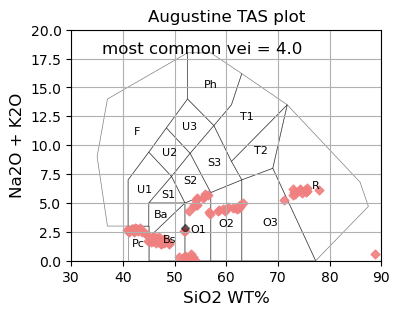

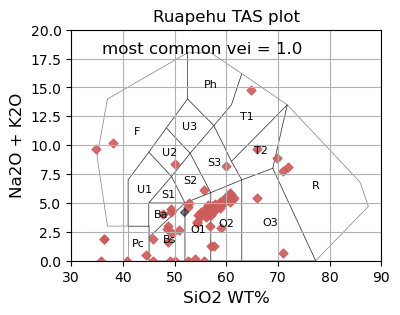

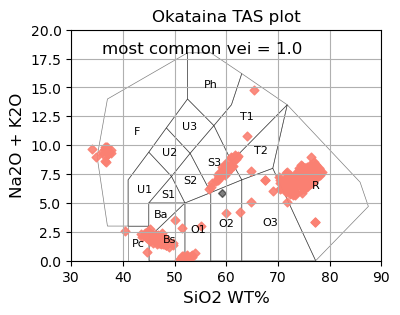

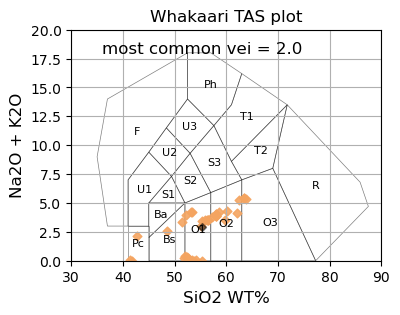

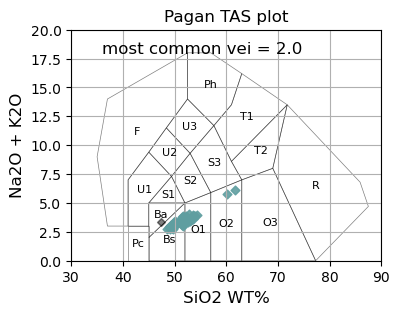

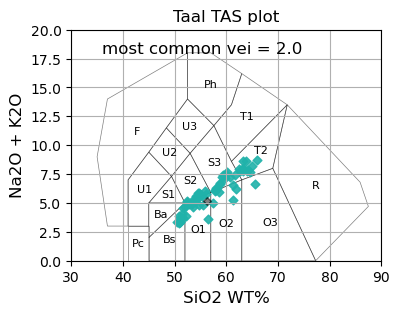

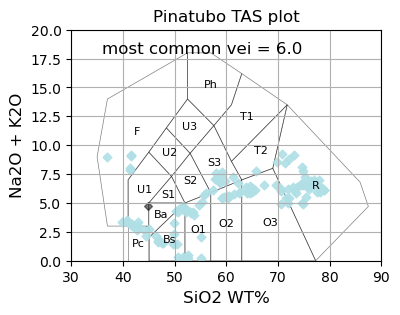

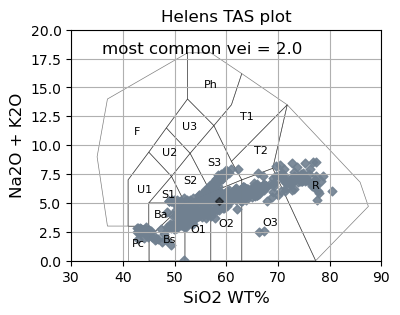

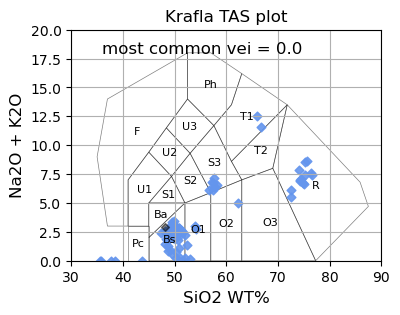

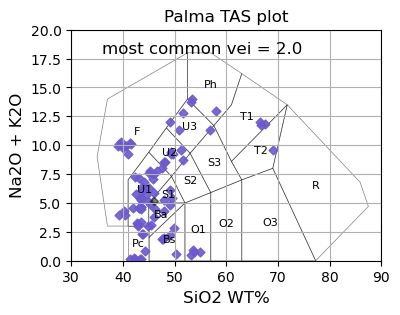

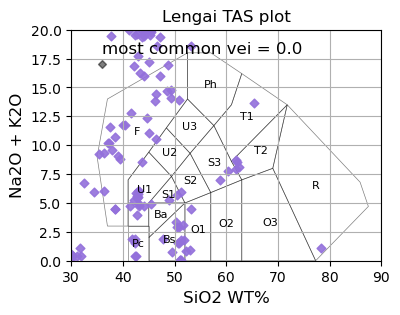

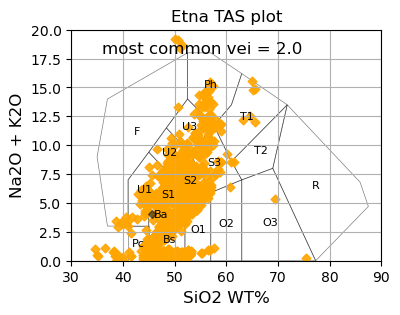

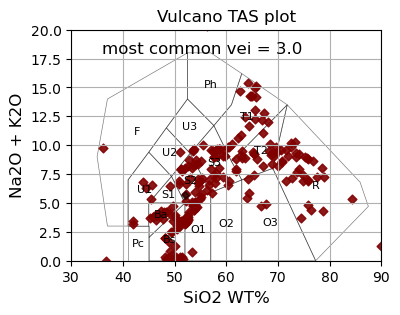

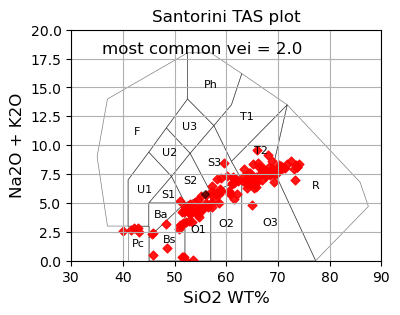

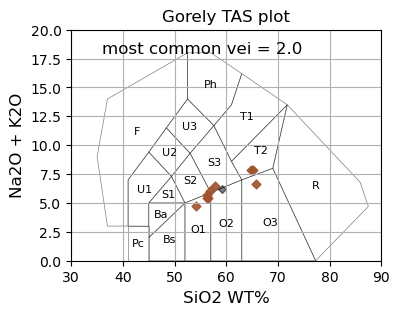

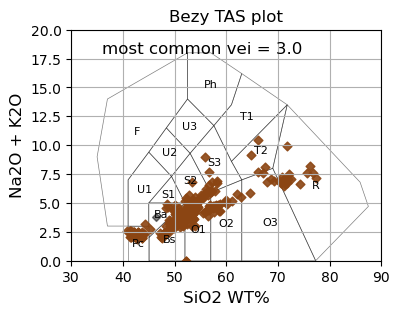

In [21]:
# https://pyrolite.readthedocs.io/en/develop/examples/util/TAS.html
# This cell would not have been possible without the information and template provided in the above resource.
cm = TAS()
position = 0
for volcano in volcanoes:
    if position == 16:
        pass
    fig, ax = plt.subplots(figsize = (4, 3))
    c = globals()[names[position] + '_chem'] = pd.read_excel(volcano, sheet_name = chem)
    cm.add_to_axes(ax, alpha=0.5, linewidth=0.5, zorder=-1, add_labels=True)

    globals()[names[position] + '_si'] = c['SiO2 WT%']
    globals()[names[position] + '_ti'] = c['TiO2 WT%']
    globals()[names[position] + '_al'] = c['Al2O3 WT%']
    globals()[names[position] + '_fe3'] = c['Fe2O3 WT%']
    globals()[names[position] + '_fe2'] = c['FeO WT%']
    globals()[names[position] + '_mn'] = c['MnO WT%']
    globals()[names[position] + '_mg'] = c['MgO WT%']
    globals()[names[position] + '_ca'] = c['CaO WT%']
    globals()[names[position] + '_na'] = c['Na2O WT%']
    globals()[names[position] + '_k'] = c['K2O WT%']
    globals()[names[position] + '_p'] = c['P2O5 WT%']
    
    c["Na2O + K2O"] = c['Na2O WT%'] + c['K2O WT%']
    c[['SiO2 WT%', "Na2O + K2O"]].plot.scatter(x = 'SiO2 WT%', y = "Na2O + K2O", 
                                              ax=ax, color = c_index[position], alpha = 0.9)
    plt.scatter(chem_index[names[position]].iloc[0], 
                chem_index[names[position]].iloc[11], color = 'black', alpha = 0.5)
    
    title = names[position]
    ax.set_title(title.capitalize() + " TAS plot")
    ax.grid()
    plt.text(0.1, 0.95, f'most common vei = {chem_index[names[position]].iloc[16]}', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.show()
    position = position + 1

**Figure 3 Caption:** Chemical profiles based on samples at each site. These TAS plots show the overall chemical (compositional) distribution of each site. Bezy is marine in origin (oceanic-oceanic boundary) and is largely basaltic, resulting in low VEI values. Santorini, Helens, and Pinatobu are more silica rich and have a much more violent eruption history.

## Discussion
**Interpretation of Results: You can't predict a natural disaster**

I found that physical behavior is erratic and that specific volcanoes do not always demonstrate an inverslsey proportional relationship between the magnitude of an earthquake and the depth of seismic activity. Some volcanoes demonstrated a definite correlation (shallow = greater magnitude) and some demonstrated the opposite (deep = greater magnitude), a few even demonstrated no significant difference between the two groups. I also found that while chemical analysis and classification of igneous rock were much more consistent and made more intuitive sense than physical analysis, the use of the mode and median values still generated inaccuracy and made preduction outside of what the data made available obsolete. With that said, the sites that I expected to be more basaltic did have lower VEI values, which demonstrates some relationship between the chemical properties and the tectonic environment (marine oceanic-oceanic boundaries are more mafic than continental-oceanic boundaries)

**Limitations and Future Work: What I should have done differently** 

I would have liked to do some more quantitive analysis on the correlation between tectonic environment and chemical properties. I think it would have been an interesting relationship to explore, and my have provided more insight on the overall correlation between the chemistry and the geological environment. When I was working with .csv files this information was available, and after switching it was not longer in a usable dataframe that I could accuratly compare to the new data. I also had an additional chemical property that I wanted to analyze with the MaGa datasets, which contain gas flux data. This would have been helpful in determining how seismic activity over time might effect volcanic output of volatiles like hydrogen sulfide gas, carbon dioxide, and hydrogen chloride gas. Unfortunatly while I had this data, I could not figure out how to read it into jupyterhub effectivley.

## References  

1. Cassidy, Mike, et al. “Controls on Explosive-Effusive Volcanic Eruption Styles.” Nature Communications, vol. 9, no. 1, 19 July 2018, p. 2839, www.nature.com/articles/s41467-018-05293-3, https://doi.org/10.1038/s41467-018-05293-3. Accessed 25 Oct. 2020.
2. “EarthChem Home: Search Geochemical Data - Contribute Data.” EarthChem, www.earthchem.org/.
3. “Figure Labels: Suptitle, Supxlabel, Supylabel — Matplotlib 3.5.2 Documentation.” Matplotlib.org, matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html.
4. GeeksforGeeks. “Python Globals() Function.” GeeksforGeeks, 19 Sept. 2018, www.geeksforgeeks.org/python-globals-function/.
5. Izz ad-Din Ruhulessin. “Accessing Dict Keys like an Attribute?” Stack Overflow, 13 Feb. 2011, stackoverflow.com/questions/4984647/accessing-dict-keys-like-an-attribute.
6. “Mount Pinatubo.” Britannica Kids, 2024, kids.britannica.com/kids/article/Mount-Pinatubo/623876.
7. Newland, Eric L., et al. “Dynamics of Deep-Submarine Volcanic Eruptions.” Scientific Reports, vol. 12, no. 1, 28 Feb. 2022, p. 3276, www.nature.com/articles/s41598-022-07351-9, https://doi.org/10.1038/s41598-022-07351-9.
8. News and Information. “News Digest: Virtually Explore Deep-Sea Volcanoes, ISchool Documentary Airs Tonight, UW Community Building Award.” UW News, 2024, www.washington.edu/news/2012/09/18/news-digest-virtually-explore-deep-sea-volcanoes-ischool-documentary-airs-tonight-uw-community-building-award/. Accessed 3 Dec. 2024.
9. “TAS Classifier — Pyrolite 0.3.6+27.Gf7ebd8d Documentation.” Readthedocs.io, 2018, pyrolite.readthedocs.io/en/develop/examples/util/TAS.html. Accessed 3 Dec. 2024.
10. “TAS for Volcanic Rocks.” Smith.edu, 2018, www.science.smith.edu/~jbrady/petrology/igrocks-tools/tas-volcanic.php. Accessed 3 Dec. 2024.
11. “What Is Lava Made Of?” Volcano World, 6 May 2010, volcano.oregonstate.edu/faq/what-lava-made.